In [3]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from scipy import stats
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression


In [5]:
import sys
sys.path.append("..")

from src.config import *

## Import clean data

In [6]:
# Read data
data_path = os.path.join(DATA_CLEAN_PATH, "ml-curated-data.csv")
dfCurated = pd.read_csv(data_path)
dfCurated.head()

,lag_11,lag_7,lag_6,lag_3,lag_2,lag_1,state,gender,age,wage_increase
0,0.024181,-0.053836,-0.023294,-0.087671,0.059876,0.032627,0.015672,0.01909,0.016816,0.075232
1,0.001615,-0.023294,-0.063004,0.059876,0.032627,0.075232,0.015672,0.01909,0.016816,-0.021322
2,0.002881,-0.063004,0.131306,0.032627,0.075232,-0.021322,0.015672,0.01909,0.016816,-0.023162
3,0.093041,0.131306,-0.087671,0.075232,-0.021322,-0.023162,0.015672,0.01909,0.016816,-0.028393
4,-0.053836,-0.087671,0.059876,-0.021322,-0.023162,-0.028393,0.015672,0.01909,0.016816,0.028896


In [7]:
target_col = "wage_increase"
features = [c for c in dfCurated.columns if c != target_col]

train = dfCurated.sample(frac=0.7)
test = dfCurated.drop(train.index)

In [8]:
train_x = train.drop(target_col, 1)
train_y = train.drop(features, 1)

test_x = test.drop(target_col, 1)
test_y = test.drop(features, 1)

In [9]:
regr = RandomForestRegressor(max_depth=1, n_estimators=5000, warm_start=True, max_features="sqrt", min_impurity_decrease=0.1)
regr.fit(train_x, np.ravel(train_y)) 

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=1,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.1, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=5000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=True)

In [10]:
estimates = regr.predict(train_x)
error = np.asmatrix(train_y.values - estimates)
sme = (error.T * error / len(error)).tolist()[0][0]
sme

0.009292455444243094

In [11]:
np.sqrt(sme)

0.09639738297403666

In [28]:
def get_random_params():
    return {
        "n_estimators": random.choice((range(1, 900))),
        "criterion": random.choice(["mse", "mae"]),
        "max_depth": random.choice(list(range(1, 100)) + [None]),
        "random_state": random.choice((range(10, 100))),
        "max_features": random.choice(range(10, 100)) / 100,
        "min_impurity_decrease": random.choice((range(10, 100)))/100,
    }

param = get_random_params()
param


{'criterion': 'mae',
 'max_depth': 99,
 'max_features': 0.39,
 'min_impurity_decrease': 0.28,
 'n_estimators': 850,
 'random_state': 95}

In [30]:
def get_rsme(df, param, target_col, features):
    train = df.sample(frac=0.7)
    test = df.drop(train.index)
    train_x = train.drop(target_col, 1)
    train_y = train.drop(features, 1)
    test_x = test.drop(target_col, 1)
    test_y = test.drop(features, 1)
    model= RandomForestRegressor(**param)
    model.fit(train_x, np.ravel(train_y))
    estimates = model.predict(train_x)
    error = np.asmatrix(train_y.values - estimates)
    sme = (error.T * error / len(error)).tolist()[0][0]
    return np.sqrt(sme) , error

In [31]:
get_rsme(dfCurated, param, target_col="wage_increase", features=[c for c in dfCurated.columns if c != "wage_increase"])

(0.09679438677811635,
 matrix([[-0.01317941, -0.01317941, -0.01317941, ..., -0.01317941,
          -0.01317941, -0.01317941],
         [-0.01037388, -0.01037388, -0.01037388, ..., -0.01037388,
          -0.01037388, -0.01037388],
         [-0.07198873, -0.07198873, -0.07198873, ..., -0.07198873,
          -0.07198873, -0.07198873],
         ...,
         [-0.10671373, -0.10671373, -0.10671373, ..., -0.10671373,
          -0.10671373, -0.10671373],
         [ 0.0083229 ,  0.0083229 ,  0.0083229 , ...,  0.0083229 ,
           0.0083229 ,  0.0083229 ],
         [ 0.16699051,  0.16699051,  0.16699051, ...,  0.16699051,
           0.16699051,  0.16699051]]))

In [ ]:
result = []
for i in range(1000):
    param = get_random_params()
    rsme , error = get_rsme(dfCurated, param, target_col="wage_increase", features=[c for c in dfCurated.columns if c != "wage_increase"])
    param["rsme"] = rsme
    param["error"] = error
    result.append(param)

In [ ]:
result_df = pd.DataFrame(result)
result_df.head()

In [ ]:
output_path = os.path.join(DATA_CLEAN_PATH, "param_random_forest_2.csv")
result_df.to_csv(output_path)

In [ ]:
result_df.max_depth.unique()
result_df.describe()

In [ ]:
result_df.rsme.min()

In [2]:
param = {'criterion': 'mse',
 'max_depth': 7,
 'max_features': 0.34,
 'min_impurity_decrease': 0.44,
 'n_estimators': 383,
 'random_state': 68}
rsme , error = get_rsme(dfCurated, param, target_col="wage_increase", features=[c for c in dfCurated.columns if c != "wage_increase"])

NameError: name 'get_rsme' is not defined

KeyboardInterrupt: 

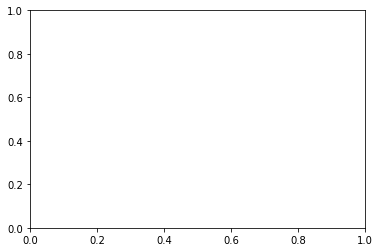

In [18]:
df_errors = pd.DataFrame({'error': [e for ls in error.tolist() for e in ls]})
df_errors.plot.kde()
plt.title("Error distribution")
plt.xlabel("Error")
plt.grid()
plt.show()

100 * df_errors.describe()

In [ ]:
test_results = pd.DataFrame(
    {
        "y": train_y.wage_increase.values,
        "y_estimate": [e for ls in estimates.tolist() for e in ls]
    }
)

100 * test_results.describe()

In [ ]:
test_results.y.plot.kde(c='r')
test_results.y_estimate.plot.kde(c='b')
plt.title("Kernel Density Estimation")
plt.grid()
plt.show()

In [ ]:
plt.plot(test_results.y, test_results.y_estimate, '.b')
plt.plot(test_results.y, test_results.y, '.r')
plt.title("Estimate VS Original")
plt.grid()
plt.show()